In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../sqlalchemy-challenge/Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
#explore columns for 'measurment' dataset
from sqlalchemy import inspect
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])



id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#explore columns for 'station' dataset
from sqlalchemy import inspect
engine.execute('SELECT * FROM station LIMIT 5').fetchall()
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Find the most recent date in the data set.
rec_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
rec_date

('2017-08-23')

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date 

datetime.date(2016, 8, 23)

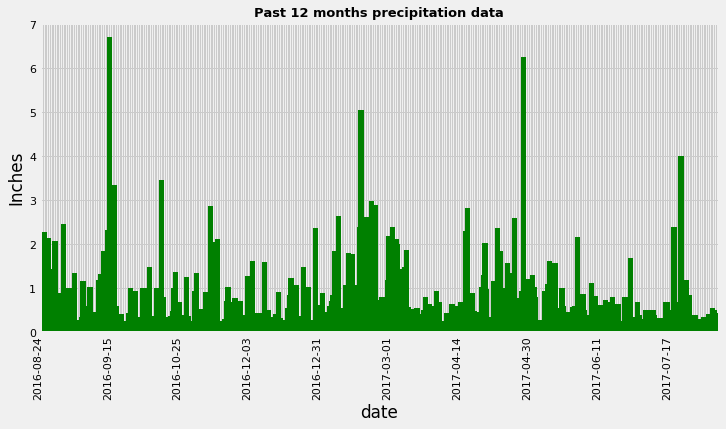

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Perform a query to retrieve the data and precipitation scores

result = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-23').\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(result)
precip_df.set_index("date", inplace = True)

# Sort the dataframe by date
precip_sort_df = precip_df.sort_index(ascending=True)
precip_nonan_df = precip_sort_df.dropna(how = 'any')

precip_nonan_df

# Use Pandas Plotting with Matplotlib to plot the data
#drop NaN and filter values > 0.2 to have a cleaner graph 
precip_nonzero_df = precip_nonan_df.loc[precip_nonan_df["prcp"] > 0.2,:]
precip_clean_df = precip_nonzero_df.dropna(how = 'any')
precip_clean_df

ax = precip_clean_df.plot(kind = "bar", figsize = (10,6), color = "g", legend=False, width  = 3)

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(precip_clean_df.index)

# Every 40th ticklable shows the year, month and day
ticklabels[::40] = precip_clean_df.index[::40]

ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

plt.gcf().autofmt_xdate()
plt.xticks(fontsize=11, rotation = 90)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.ylabel("Inches")
plt.title("Past 12 months precipitation data", fontsize = 13, fontweight = 'bold')

plt.savefig("../sqlalchemy-challenge/Images/precipitation.png")
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_nonan_df.agg({"prcp": ['mean','median','min', 'max', 'var','std', ]})

,prcp
mean,0.176462
median,0.020000
min,0.000000
max,6.700000
var,0.211865
std,0.460288


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
stations_count=session.query(func.count(Station.station)).all()
#print(f' number of station is {stations_count}')
stations_count


[(9)]

In [15]:
#Design a query to find the most active stations (i.e. which stations have the most rows?).
#List the stations and observation counts in descending order.
active_stn = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

active_stn

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
#Which station id has the highest number of observations?
most_active = active_stn[0][0]
print(f'The station with the highest number of observations is {most_active}')

The station with the highest number of observations is USC00519281


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_st_stat = session.query(Measurement.station, Station.name, func.min(Measurement.tobs),\
        func.max(Measurement.tobs), func.avg(Measurement.tobs),func.count(Measurement.tobs)).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.station == most_active).\
        group_by(Measurement.station).all()

print(f'the temperature statistics for the most active station "{active_st_stat[0][1]}" is: ')
print(f' - lowest temperature is {active_st_stat[0][2]}; ')
print(f' - highest temperature is {active_st_stat[0][3]};')
print(f' - average temperature is {active_st_stat[0][4]};')
print(f' - total number of observations is {active_st_stat[0][5]} ')


the temperature statistics for the most active station "WAIHEE 837.5, HI US" is: 
 - lowest temperature is 54.0; 
 - highest temperature is 85.0;
 - average temperature is 71.66378066378067;
 - total number of observations is 2772 


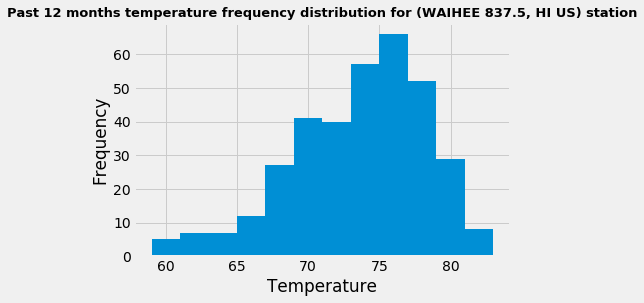

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_st_temp = session.query(Measurement.tobs).\
                filter(Measurement.date > '2016-08-23').\
                filter(Measurement.station == most_active).all()
active_st_temp

# Save the query results as a Pandas DataFrame and set the index to the date column
active_st_temp_df = pd.DataFrame(active_st_temp)
#active_st_temp_df.set_index("date", inplace = True)
active_st_temp_df.hist(bins = 12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Past 12 months temperature frequency distribution for " + "(" + active_st_stat[0][1] +")"+ " station", fontsize = 13, fontweight = 'bold')
plt.savefig("../sqlalchemy-challenge/Images/histogram.png")
plt.show()

# Close session

In [ ]:
# Close Session
session.close()